In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau

In [2]:
df = pd.read_csv('data/SolarPrediction.csv', usecols = ['Radiation', 'Temperature', 'Humidity', 'WindDirection(Degrees)', 'Speed'])

In [3]:
df.head(3)

,Radiation,Temperature,Humidity,WindDirection(Degrees),Speed
0,1.21,48,59,177.39,5.62
1,1.21,48,58,176.78,3.37
2,1.23,48,57,158.75,3.37


In [4]:
corr = df.corr(method='kendall')

In [5]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, False)

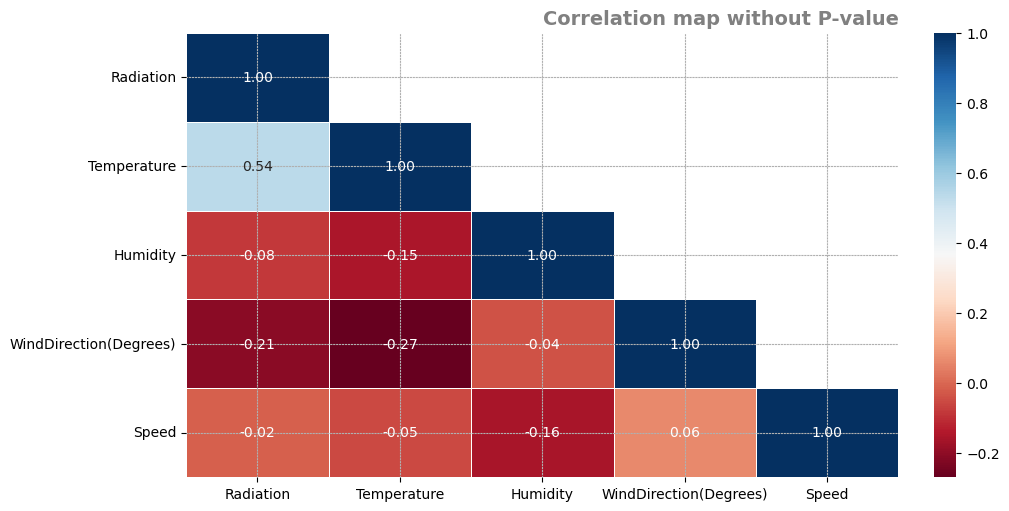

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title('Correlation map without P-value', fontsize=14)

# Generate the heatmap including the mask
heatmap = sns.heatmap(corr,
                      annot=True,
                      annot_kws={"fontsize": 10},
                      fmt='.2f',
                      linewidths=0.5,
                      cmap='RdBu',
                      mask=mask, # the mask has been included here
                      ax=ax)

# Display our plot
plt.show()

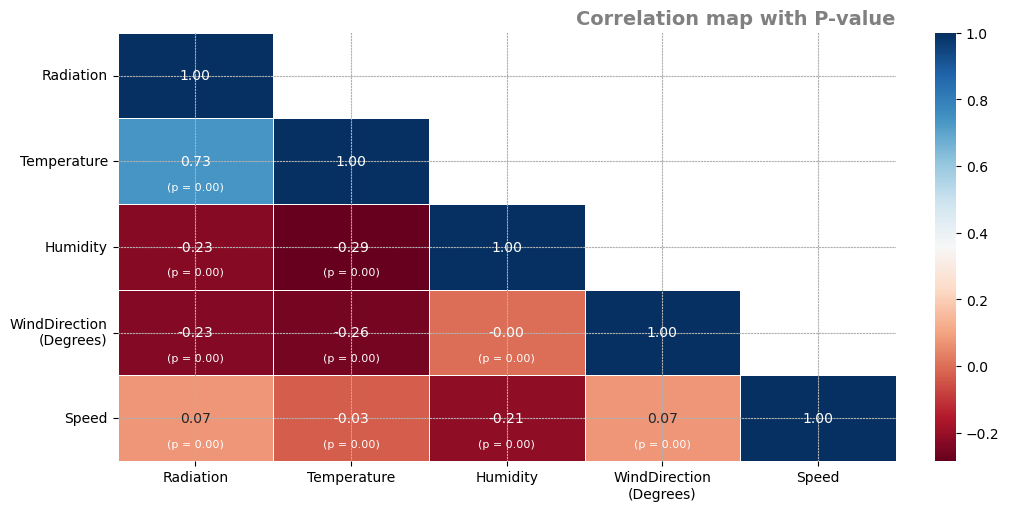

In [7]:
# Generate the correlation matrix afresh
corr = df.corr(numeric_only=True)

# mask the correlation matrix to diagonal
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, False)

fix,ax = plt.subplots(figsize=(10,5))
plt.title("Correlation map with P-value", fontsize=14)

# Generate heatmap
heatmap = sns.heatmap(corr,
                      annot= True,
                      annot_kws={"fontsize": 10},
                      fmt='.2f',
                      linewidths=0.5,
                      cmap='RdBu',
                      mask=mask,
                      ax=ax)

# calculate and format p-values
p_values = np.full((corr.shape[0], corr.shape[1]), np.nan)
for i in range(corr.shape[0]):
  for j in range(i+1, corr.shape[1]):
    x = df.iloc[:, i]
    y = df.iloc[:, j]
    mask = ~np.logical_or(np.isnan(x), np.isnan(y))
    if np.sum(mask) > 0:
      p_values[i, j] = kendalltau(x[mask], y[mask])[1] #change to pearsonr or spearmanr

# Create a dataframe object for p_values
p_values = pd.DataFrame(p_values, columns=corr.columns, index=corr.index)

# Mask the p values
mask_pvalues = np.triu(np.ones_like(p_values), k=1)

# Generate maximum and minimum correlation coefficients for p-value annotation color
max_corr = np.max(corr.max())
min_corr = np.min(corr.min())

# Assign the p-value annotations to our correlation matrix
for i in range (p_values.shape[0]):
  for j in range(p_values.shape[1]):
    if mask_pvalues[i, j]:
      p_value = p_values.iloc[i, j]
      if not np.isnan(p_value):
        correlation_value = corr.iloc[i, j]
        text_color = 'white' if correlation_value >= (max_corr - 0.4) or correlation_value <= (min_corr + 0.4) else 'black'
        ax.text(i+0.5, j + 0.8, f'(p = {p_value:.2f})',
                horizontalalignment = 'center',
                verticalalignment = 'center',
                fontsize=8,
                color=text_color)

# Customize x-axis labels
x_labels = [textwrap.fill(label.get_text(), 13) for label in ax.get_xticklabels()]
ax.set_xticklabels(x_labels, rotation=0, ha="center")

# Customize y-axis labels
y_labels = [textwrap.fill(label.get_text(), 13) for label in ax.get_yticklabels()]
ax.set_yticklabels(y_labels, rotation=0, ha="right")

# Display the plot
plt.show()

In [8]:
def corr_matrix_with_pval(df, method = 'pearson', figsize=(20, 10), title=None):
  """
  df: dataframe to be used. Ensured the dataframe has been sliced to contain only the column you need. It accepts only numerical columns
  method: default uses the pearson method. It overall permits 3 methods; 'pearson', 'spearman' and 'kendall'
  figsize: default is (20, 10) but you can change it based on your preference
  title: Specify the title for your chart, default is None
  """
  # Make a copy of the df
  data = df.copy()
  # Check features correlation
  corr = data.corr(method = method)

  # Create a mask to hide the upper triangle
  mask = np.zeros_like(corr, dtype=bool)
  mask[np.triu_indices_from(mask)] = True

  # Set the diagonal elements of the mask to False to display self-correlation
  np.fill_diagonal(mask, False)

  fig, ax = plt.subplots(figsize=figsize)
  plt.title(title, fontsize=14)

  # Create the heatmap with the custom mask
  heatmap = sns.heatmap(corr,
                        annot=True,
                        annot_kws={"fontsize": 10},  # Adjust annotation font size
                        fmt='.2f',
                        linewidths=0.5,
                        cmap='RdBu',
                        mask=mask,
                        ax=ax)

  # Create a function to calculate and format p-values
  p_values = np.full((corr.shape[0], corr.shape[1]), np.nan)
  for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[1]):
      x = data.iloc[:, i]
      y = data.iloc[:, j]
      mask = ~np.logical_or(np.isnan(x), np.isnan(y))
      if np.sum(mask) > 0:
        if method == 'pearson':
          p_values[i, j] = pearsonr(x[mask], y[mask])[1] #Changes based on the method chosen in the function
        elif method == 'kendall':
          p_values[i, j] = kendalltau(x[mask], y[mask])[1]
        elif method == 'spearman':
          p_values[i, j] = spearmanr(x[mask], y[mask])[1]

  p_values = pd.DataFrame(p_values, columns=corr.columns, index=corr.index)

  # Create a mask for the p-values heatmap
  mask_pvalues = np.triu(np.ones_like(p_values), k=1)

  # Calculate the highest and lowest correlation coefficients
  max_corr = np.max(corr.max())
  min_corr = np.min(corr.min())

  # Annotate the heatmap with p-values and change text color based on correlation value
  for i in range(p_values.shape[0]):
    for j in range(p_values.shape[1]):
      if mask_pvalues[i, j]:
        p_value = p_values.iloc[i, j]
        if not np.isnan(p_value):
          correlation_value = corr.iloc[i, j]
          text_color = 'white' if correlation_value >= (max_corr - 0.4) or correlation_value <= (min_corr + 0.4) else 'black'
          ax.text(i + 0.5, j + 0.8, f'(p = {p_value:.2f})',
                  horizontalalignment='center',
                  verticalalignment='center',
                  fontsize=8,
                  color=text_color)

  # Customize x-axis labels
  x_labels = [textwrap.fill(label.get_text(), 13) for label in ax.get_xticklabels()]
  ax.set_xticklabels(x_labels, rotation=0, ha="center")

  # Customize y-axis labels
  y_labels = [textwrap.fill(label.get_text(), 13) for label in ax.get_yticklabels()]
  ax.set_yticklabels(y_labels, rotation=0, ha="right")

  plt.show()

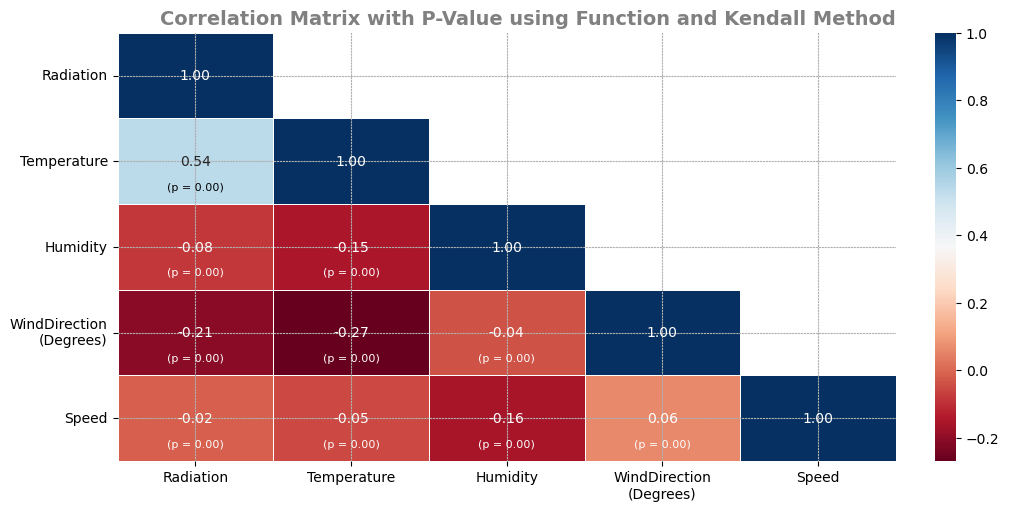

In [9]:
# Plot correlation matrix with pvalue in one line of code using kendall method
corr_matrix_with_pval(df, method = 'kendall', figsize=(10,5), title='Correlation Matrix with P-Value using Function and Kendall Method')